# MULTI-ARM BANDITS

In [1]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Epsilon-greedy policies

In [2]:
class epsilon_bandit:
    """
    Epsilon-greedy bandit.
    Attributes are divided in model parameters, simulation data to return and distributions parameters.
    """

    def __init__(self, eps, opt_init, init_means, sigmas_a, arms=10, alpha=None, iters=10000, stationary=True):
        """Initializes the bandit object and its attributes."""
        # Model variables initialization.
        self.arms = arms
        self.eps = eps
        self.alpha = alpha
        self.Q_a = np.full(arms, opt_init)
        self.qs_a = init_means
        self.sigmas_a = sigmas_a
        self.iters = iters
        self.stationary = stationary
        self.N_a = np.zeros(arms)        
        # Simulation data initialization.
        self.avg_rewards = np.zeros(iters + 1)
        self.Qs = np.zeros((iters + 1, arms))
        self.Qs[0, :] = self.Q_a
        self.qs = np.zeros((iters + 1, arms))
    
    def choose_action(self):
        """
        Implements the epsilon-greedy policy: exploits knowledge or explores new possibilities.
        """
        choice = np.random.choice([0, 1], p=[1-self.eps, self.eps])
        if choice == 0:
            # Greedy choice.
            return np.argmax(self.Q_a)
        else:
            # Explorative choice.
            return np.random.choice(list(range(0, self.arms)))
        
    def pull_arm(self, arm):
        """Draws a reward using a normal distribution you can set."""
        return np.random.normal(self.qs_a[arm], self.sigmas_a[arm])
        
    def update(self, arm, reward, iteration):
        """Updates estimates and other data after an episode."""
        # Decrease exploration probability.
        if (self.stationary == True) and (self.eps >= ((self.eps / self.iters) * (iteration + 1))):
            self.eps -= (self.eps / self.iters) * (iteration + 1)
        # Update choice count.
        self.N_a[arm] += 1
        # Update reward estimate and eventually real reward means.
        if self.stationary == True:
            self.Q_a[arm] += (1 / self.N_a[arm]) * (reward - self.Q_a[arm])
        else:
            self.Q_a[arm] += self.alpha * (reward - self.Q_a[arm])
            for i in range(self.arms):
                self.qs_a[i] += np.random.normal()
        # Update simulation data.
        self.avg_rewards[iteration + 1] = self.avg_rewards[iteration] + ((1/(iteration + 1)) * (reward - self.avg_rewards[iteration])) 
        self.Qs[iteration + 1, :] = self.Qs[iteration, :]
        self.Qs[iteration + 1, arm] = self.Q_a[arm]
        self.qs[iteration + 1, :] = self.qs_a

    def get_sim_data(self):
        """Returns episodes simulation data."""
        return (self.iters + 1, np.copy(self.avg_rewards), np.copy(self.N_a), np.copy(self.qs), np.copy(self.Qs))
        
    def run(self):
        """Runs a set of episodes."""
        for i in range(self.iters):
            arm = self.choose_action()
            reward = self.pull_arm(arm)
            self.update(arm, reward, i)

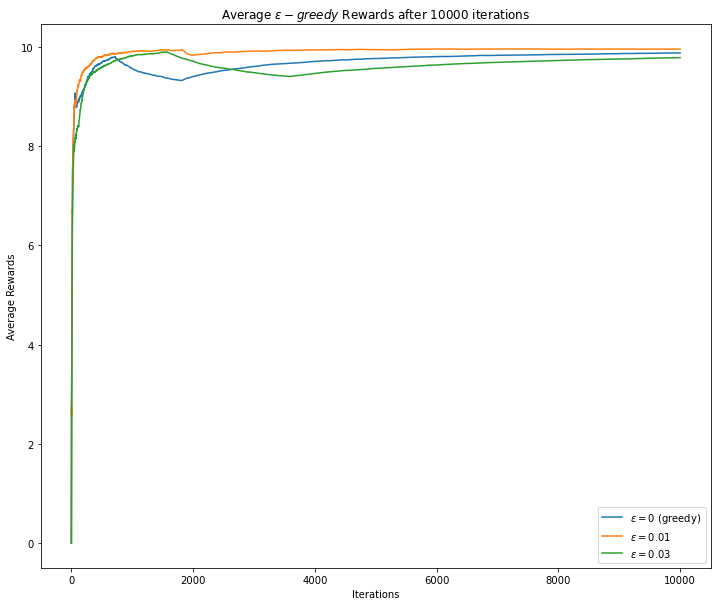

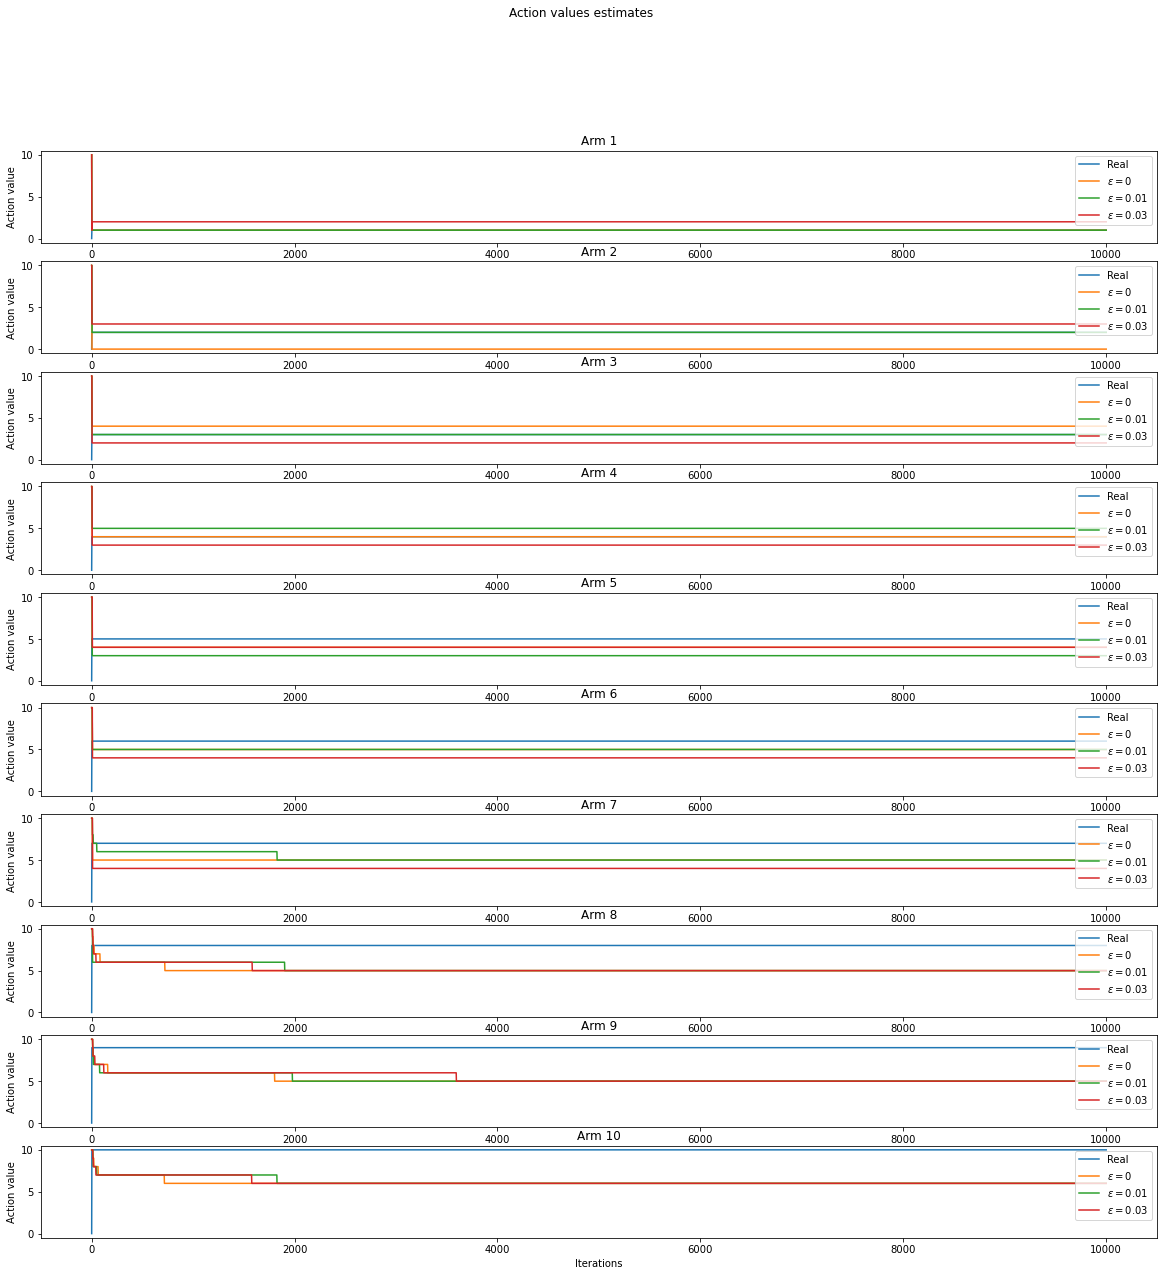

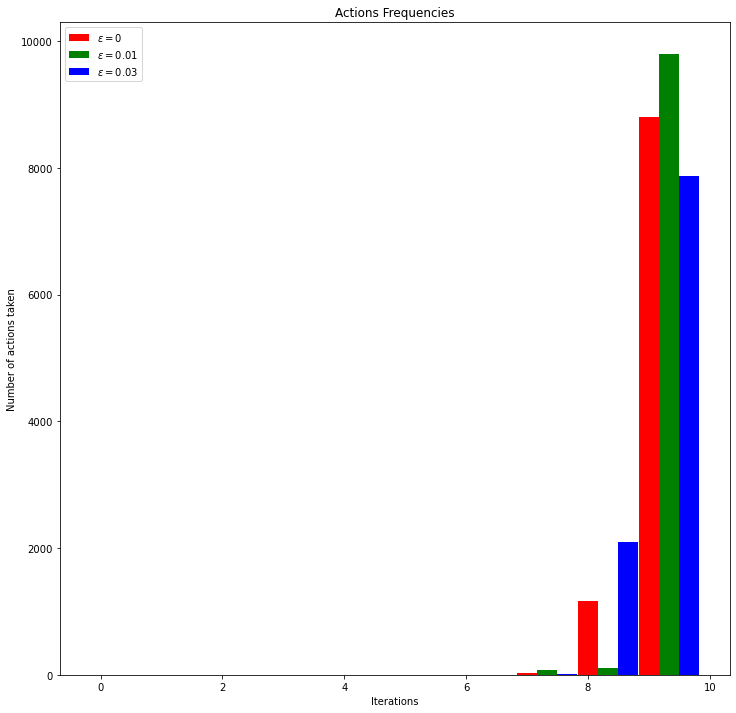

In [3]:
# Simulation parameters.
opt_init = 10
arms = 10
init_means = list(range(1, arms+1))
sigmas = np.full(arms, 1)

# Bandits initialization.
bandit_0 = epsilon_bandit(0, opt_init, init_means, sigmas)
bandit_01 = epsilon_bandit(0.01, opt_init, init_means, sigmas)
bandit_03 = epsilon_bandit(0.03, opt_init, init_means, sigmas)

# Episodes.
bandit_0.run()
bandit_01.run()
bandit_03.run()

# Data gathering.
iters_0, rew_0, N_0, qs_0, Qs_0 = bandit_0.get_sim_data()
iters_01, rew_01, N_01, qs_01, Qs_01 = bandit_01.get_sim_data()
iters_03, rew_03, N_03, qs_03, Qs_03 = bandit_03.get_sim_data()

# Reward plots.
plt.figure(figsize=(12, 10))
plt.plot(rew_0, label="$\epsilon=0$ (greedy)")
plt.plot(rew_01, label="$\epsilon=0.01$")
plt.plot(rew_03, label="$\epsilon=0.03$")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Average Rewards")
plt.title("Average $\epsilon-greedy$ Rewards after " + str(iters_0-1) + " iterations")
plt.show()

# Estimates plots.
fig, ax = plt.subplots(arms, figsize=(20, 20))
fig.suptitle('Action values estimates')
for i in range(arms):
    ax[i].plot(qs_0[:, i], label="Real")
    ax[i].plot(Qs_0[:, i], label="$\epsilon=0$")
    ax[i].plot(Qs_01[:, i], label="$\epsilon=0.01$")
    ax[i].plot(Qs_03[:, i], label="$\epsilon=0.03$")
    ax[i].legend(loc='upper right')
    ax[i].set(xlabel='Iterations', ylabel='Action value')
    ax[i].set_title("Arm " + str(i + 1))

# Frequency plots.
bins = np.linspace(0, arms - 1, arms)
plt.figure(figsize=(12, 12))
plt.bar(bins, N_0, width=0.33, color='r', label='$\epsilon=0$')
plt.bar(bins + 0.33, N_01, width=0.33, color='g', label='$\epsilon=0.01$')
plt.bar(bins + 0.66, N_03, width=0.33, color='b', label='$\epsilon=0.03$')
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Number of actions taken")
plt.title("Actions Frequencies")
plt.show()